In [7]:
## Imports

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import ascii
import pickle
import os
from scipy import integrate
from scipy.integrate import quad
from scipy.integrate import odeint
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from datetime import datetime


import astropy
from astropy import units as u
from astropy.time import Time


In [8]:

# where I saved the folder w/ data on my laptop
data_basepath = '/Users/akivasherin/Desktop/Summer_Reasearch/PhysNotebooks/data/IceCube_data_from_2008_to_2017_related_to_analysis_of_TXS_0506+056'

# Paths to event files

IC40_events_path = os.path.join(data_basepath ,'events_IC40.txt')
IC59_events_path = os.path.join(data_basepath ,'events_IC59.txt')
IC79_events_path = os.path.join(data_basepath ,'events_IC79.txt')
IC86a_events_path = os.path.join(data_basepath ,'events_IC86a.txt')
IC86b_events_path = os.path.join(data_basepath ,'events_IC86b.txt')
IC86c_events_path = os.path.join(data_basepath ,'events_IC86c.txt')


# Read in event files
# Note: using ascii.read and then later convert to pandas dataframe because
# ascii.read parses data columns more easily / correctly, but lots of 
# useful functions already written use pandas dataframes.

IC40_events = ascii.read(IC40_events_path)
IC59_events = ascii.read(IC59_events_path)
IC79_events = ascii.read(IC79_events_path)
IC86a_events = ascii.read(IC86a_events_path)
IC86b_events = ascii.read(IC86b_events_path)
IC86c_events = ascii.read(IC86c_events_path)


# Compute & append sin(declination) and log10(angular error), for later 
# use in signal & background pdfs. Also want column named "log10(E/GeV)"
# to fit with use in some functions.

IC40_events['sin_dec'] = np.sin(np.radians(IC40_events['Dec_deg']))
IC59_events['sin_dec'] = np.sin(np.radians(IC59_events['Dec_deg']))
IC79_events['sin_dec'] = np.sin(np.radians(IC79_events['Dec_deg']))
IC86a_events['sin_dec'] = np.sin(np.radians(IC86a_events['Dec_deg']))
IC86b_events['sin_dec'] = np.sin(np.radians(IC86b_events['Dec_deg']))
IC86c_events['sin_dec'] = np.sin(np.radians(IC86c_events['Dec_deg']))

IC40_events['log10(ang_err)'] = np.log10(np.radians(IC40_events['Unc_deg']))
IC59_events['log10(ang_err)'] = np.log10(np.radians(IC59_events['Unc_deg']))
IC79_events['log10(ang_err)'] = np.log10(np.radians(IC79_events['Unc_deg']))
IC86a_events['log10(ang_err)'] = np.log10(np.radians(IC86a_events['Unc_deg']))
IC86b_events['log10(ang_err)'] = np.log10(np.radians(IC86b_events['Unc_deg']))
IC86c_events['log10(ang_err)'] = np.log10(np.radians(IC86c_events['Unc_deg']))

IC40_events['log10(E/GeV)'] = IC40_events['log10(Ereco)']
IC59_events['log10(E/GeV)'] = IC59_events['log10(Ereco)']
IC79_events['log10(E/GeV)'] = IC79_events['log10(Ereco)']
IC86a_events['log10(E/GeV)'] = IC86a_events['log10(Ereco)']
IC86b_events['log10(E/GeV)'] = IC86b_events['log10(Ereco)']
IC86c_events['log10(E/GeV)'] = IC86c_events['log10(Ereco)']





# Now put all event lists together into one dict
# for easier reference later

full_events = dict()

full_events['IC40'] = IC40_events
full_events['IC59'] = IC59_events
full_events['IC79'] = IC79_events
full_events['IC86a'] = IC86a_events
full_events['IC86b'] = IC86b_events
full_events['IC86c'] = IC86c_events


# Paths to effective area files

IC40_aeff_path = os.path.join(data_basepath ,'Aeff_IC40.txt')
IC59_aeff_path = os.path.join(data_basepath ,'Aeff_IC59.txt')
IC79_aeff_path = os.path.join(data_basepath ,'Aeff_IC79.txt')
IC86a_aeff_path = os.path.join(data_basepath ,'Aeff_IC86a.txt')
IC86b_aeff_path = os.path.join(data_basepath ,'Aeff_IC86b.txt')
IC86c_aeff_path = os.path.join(data_basepath ,'Aeff_IC86c.txt')

# Read in files

IC40_aeff = ascii.read(IC40_aeff_path)
IC59_aeff = ascii.read(IC59_aeff_path)
IC79_aeff = ascii.read(IC79_aeff_path)
IC86a_aeff = ascii.read(IC86a_aeff_path)
IC86b_aeff = ascii.read(IC86b_aeff_path)
IC86c_aeff = ascii.read(IC86c_aeff_path)


full_aeff = dict()

full_aeff['IC40'] = IC40_aeff
full_aeff['IC59'] = IC59_aeff
full_aeff['IC79'] = IC79_aeff
full_aeff['IC86a'] = IC86a_aeff
full_aeff['IC86b'] = IC86b_aeff
full_aeff['IC86c'] = IC86c_aeff


# Load Pprop spline from file
# This is Prob(est E_mu | orig E_nu)
with open('data/P-EmuHat-Enu-IC.pkl', 'rb') as ifile:
    PpropIC = pickle.load(ifile)



/var/folders/dr/tnb6gyns3kl9xhswdbqkpm_00000gn/T/ipykernel_33604/401936169.py:101: DeprecationWarning: Please import `interp2d` from the `scipy.interpolate` namespace; the `scipy.interpolate.interpolate` namespace is deprecated and will be removed in SciPy 2.0.0.
  PpropIC = pickle.load(ifile)


In [9]:
# return effective area spline for given data set & declination.
# aeff in cm^2 as function of log10(energy/GeV) between 2 and 6
def aeff_spline(this_data,dec):
    aeff_raw = full_aeff[this_data]
    L = len(aeff_raw)
    emin_list = []
    emax_list = []
    aeff_list = []
    for i in range(0,L):
        emin_list.append(aeff_raw['log10(Emin/GeV)'][i])
        emax_list.append(aeff_raw['log10(Emax/GeV)'][i])
        aeff_list.append(aeff_raw['Aeff[m2]'][i])
    
    # make sure that spline definitely covers log(E):2-->6 w/o messing up too much
    L2 = len(emin_list)
    energy_list = []
    energy_list.append(1.999)
    aeff_list_2 = []
    aeff_list_2.append(0.0)
    energy_list.append(emin_list[0])
    aeff_list_2.append(aeff_list[0])
    for i in range(0,L2):
        energy_list.append(0.5*(emin_list[i]+emax_list[i]))
        aeff_list_2.append(aeff_list[i])
    energy_list.append(emax_list[L2-1])
    aeff_list_2.append(aeff_list[L2-1])
    
    spline = interp1d(energy_list,aeff_list_2,kind='linear')
    return spline


# Define source and select appropriate data

# source coordinates
# TXS 0506+056

src_ra = 77.3581667
src_dec = 5.6931472
sin_src_dec = np.sin(np.radians(src_dec))


data_set_list = ['IC40','IC59','IC79','IC86a','IC86b','IC86c']

# number of events in all-sky sample
N = 0
for data_set in data_set_list:
    N += len(full_events[data_set]['log10(Ereco)'])
print('Total all-sky events, N =',N)

# Function to compute angular distance (used for psi b/w source and event).
# Coordinates given in degrees
def angular_distance(ra_1, dec_1, ra_2, dec_2):
        delta_dec = np.radians(dec_1 - dec_2)
        delta_ra = np.radians(ra_1 - ra_2)
        x = (np.sin(delta_dec / 2.))**2. + np.cos(dec_1) *\
            np.cos(dec_2) * (np.sin(delta_ra / 2.))**2.
        return np.degrees(2. * np.arcsin(np.sqrt(np.abs(x))))


# define function to select & return appropriate events based on location.
# Also elminate events outside of interpolation range, log10(E):2-->6.
# For the TXS-specific data release, this 
def select_data_radius(data_set,sra_deg,sdec_deg,rad_deg): # rad = right ascencsion
    # ascii.read better for importing, but pandas better for working w/ data
    data = data_set.to_pandas()
    # Rough cut at first, elminates some weird results:
    # (Possible issues w/ quadrant, look into this later. Works for TXS...)
    # Not elegant but fine for now.
    data2 = data.loc[data['Ra_deg'] < sra_deg+rad_deg].copy()
    data3 = data2.loc[data2['Ra_deg'] > sra_deg-rad_deg].copy()
    data4 = data3.loc[data3['Dec_deg'] < sdec_deg+rad_deg].copy()
    data5 = data4.loc[data4['Dec_deg'] > sdec_deg-rad_deg].copy()
    data6 = data5.loc[data5['log10(Ereco)'] >= 2.0].copy()
    data7 = data6.loc[data6['log10(Ereco)'] <= 6.0].copy()
    data7['psi'] = angular_distance(sra_deg,sdec_deg,data7['Ra_deg'],data7['Dec_deg'])
    return_data = data7.loc[data7['psi'] < rad_deg].copy()
    return return_data

selected_events = dict()
for data_set in data_set_list:
    # select data w/in 15 degrees of source to reduce compute time
    selected_events[data_set] = select_data_radius(full_events[data_set],src_ra,src_dec,5)

# Putting selected data into the format which will be used below.
src_data = dict()
src_data['IC40'] = [selected_events['IC40'],aeff_spline('IC40',src_dec)]
src_data['IC59'] = [selected_events['IC59'],aeff_spline('IC59',src_dec)]
src_data['IC79'] = [selected_events['IC79'],aeff_spline('IC79',src_dec)]
src_data['IC86a'] = [selected_events['IC86a'],aeff_spline('IC86a',src_dec)]
src_data['IC86b'] = [selected_events['IC86b'],aeff_spline('IC86b',src_dec)]
src_data['IC86c'] = [selected_events['IC86c'],aeff_spline('IC86c',src_dec)]


# Length of selected data
Np = 0.
for data_set in data_set_list:
    Np += len(src_data[data_set][0])
print('Np =',Np)
DeltaN = N - Np
print('Delta N =',DeltaN)

Total all-sky events, N = 1257
Np = 1254.0
Delta N = 3.0


In [10]:
# Use the different A_eff for each data set to produce a
# signal pdf corresponding to each data set

# energy_pdf takes gamma value, name of dataset (string), source declination (degrees);
# returns a normalized spline over the range log_10(E/GeV): 2-->6.

def energy_pdf(gamma,dataset_name,dec):
    
    l10_energies = np.linspace(2,6,100)
    epdf_values = []
    
    # get effective area spline for this data set and declination
    aeff = aeff_spline(dataset_name,dec)
    # note aeff(log10(E)), not aeff(E)
    
    # Iterate over observed muon energies.
    # For each muon energy, integrate over possible neutrino energies
    
    for i in range(0,len(l10_energies)):
        eps_mu = l10_energies[i]
        # integration variable x is log10(neutrino energy)
        integral = integrate.quad(lambda x: (10**x) * aeff(x) * (10**x)**(-gamma) * PpropIC(x,eps_mu),2,6)[0]
        epdf_values.append(integral)
    
    # spline interpolation of unnormalized epdf values:
    epdf_spline = interp1d(l10_energies,epdf_values,kind='cubic')
    
    # normalization factor:
    norm = integrate.quad(lambda x: epdf_spline(x),2,6)[0]
    
    # Now make normalized spline to return
    norm_pdf = epdf_spline(l10_energies)/norm
    norm_pdf_spline = interp1d(l10_energies,norm_pdf,kind='cubic')
    
    return norm_pdf_spline



/var/folders/dr/tnb6gyns3kl9xhswdbqkpm_00000gn/T/ipykernel_33604/1965502425.py:22: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  integral = integrate.quad(lambda x: (10**x) * aeff(x) * (10**x)**(-gamma) * PpropIC(x,eps_mu),2,6)[0]


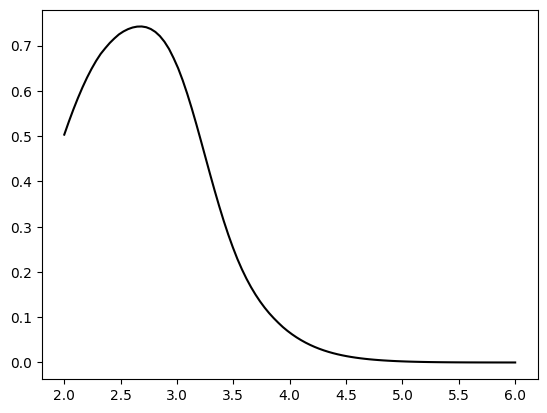

In [12]:
# Example of an IC40 pdf

test_pdf = energy_pdf(3.0,'IC86a',src_dec)

test_log_energies = np.linspace(2,6,100)

plt.plot(test_log_energies, test_pdf(test_log_energies),'k')